# **Udacity Data Analyst Nanodegree**

## **Project 6: Identify Fraud from Enron Email**

*by Homagni Bhattachajee*

### **Project Overview**

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.

In this project I will build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case. A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity. This report documents the machine learning techniques used in building a POI identifier.

There are four major steps in my project:

1. Enron dataset
2. Feature processing
3. Algorithm
4. Validation

### **Exploring the dataset**

In [1]:
#Importing necessary modules

import os
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)# setting seed number

from feature_format import featureFormat, targetFeatureSplit
from pprint import pprint
from tester import dump_classifier_and_data

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.cross_validation import train_test_split
from feature_format import featureFormat, targetFeatureSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from time import time
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import svm


C:\Users\Homagni Bhattacharje\Miniconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Homagni Bhattacharje\Miniconda3\envs\py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Loading data
data_dict = pickle.load( open("../final_project/final_project_dataset.pkl", "r") )

In [3]:
# number of people
print "There are ", len(data_dict), "excecutives in Enron Dataset"

There are  146 excecutives in Enron Dataset


In [4]:
# name of all the excecutives
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

There are one name that was not a person name 'THE TRAVEL AGENCY IN THE PARK'. This was an outlier.

In [5]:
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [6]:
# number of features
print "There are ", len(data_dict['SKILLING JEFFREY K'].keys()), "features in the Enron Dataset"

There are  21 features in the Enron Dataset


In [7]:
# list of features
print "List of features: " + "\n" + str(data_dict['SKILLING JEFFREY K'].keys())

List of features: 
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [8]:
# count people of interest
count_poi = 0
poi_name = []
for entry in data_dict:
    if data_dict[entry]['poi'] == 1:
        count_poi += 1
        poi_name.append(entry)
print "There are " + str(count_poi) + " person of interest."
print poi_name

There are 18 person of interest.
['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H', 'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F']


Let's explore something more about those POIs.

In [9]:
#How many data have “NaN” for their "long-term-incentives"
count_total_incentives_NaN = 0
for entry in data_dict:
    if data_dict[entry]['long_term_incentive'] == 'NaN':
        count_total_incentives_NaN += 1
print 'NaN data for long_term_incentives:', count_total_incentives_NaN

NaN data for long_term_incentives: 79


In [10]:
#How many folks in this dataset have a 'NaN' salary? 
count_salary = 0
for entry in data_dict:
    if data_dict[entry]['salary'] == 'NaN':
        count_salary +=1
print 'NaN for salary:', count_salary

NaN for salary: 50


In [11]:
# Any data that all 'NaN' in main features:
for entry in data_dict:
    if data_dict[entry]['director_fees'] == 'NaN' and data_dict[entry]['total_stock_value'] == 'NaN' and data_dict[entry]['total_payments'] == 'NaN':
        print entry

LOCKHART EUGENE E


In [12]:
data_dict['LOCKHART EUGENE E']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

So this person LOCKHART EUGENE E had all the features in NaN and was not a POI. This person was an outlier.

Let's explore some bivariative relationship between some quantitative features from the Enron dataset.

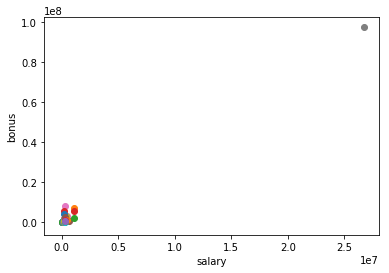

In [13]:
# SALARY VS BONUS

sys.path.append("../tools/")
### read in data dictionary, convert to numpy array
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

### plot
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )
matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

We can see that there was an outlier that was extremely higher than the rest of the data. Let's come back to the dataset and see what was the data point.

In [14]:
# remove NaN's and find max salary 
salary_list = []
for entry in data_dict:
    if type (data_dict[entry]['salary']) == int :
        salary_list.append(data_dict[entry]['salary'])
print "Total people with salary: " + str(len(salary_list))
print "Maxium salary was " + str(max(salary_list))

Total people with salary: 95
Maxium salary was 26704229


In [15]:
# find person with max salary
for entry in data_dict:
    if data_dict[entry]['salary'] == 26704229: # Maximum Salary = 26704229
        print "Name of person with maximum salary " + entry

Name of person with maximum salary TOTAL


So, the outlier was the TOTAL salary and bonus. I removed it from the dataset

In [16]:
# remove outlier from the data
data_dict.pop('TOTAL',0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [17]:
# average salary
print "Average salary: " + str(int(np.mean(salary_list)))

Average salary: 562194


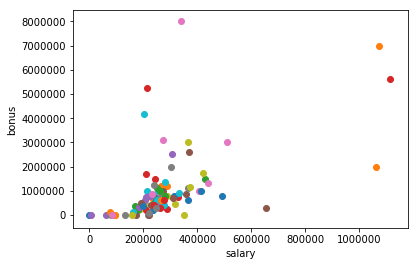

In [18]:
# Replot SALARY VS BONUS after removing outlier

data_dict.pop('TOTAL', 0)
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

### plot
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

We would argue that there’s 4 more outliers to investigate; let's look at a couple of them. Two people made bonuses of at least 5 million dollars, and a salary of over 1 million dollars; in other words, they got richly rewarded. What are the names associated with those point? Are they POIs?

In [19]:
# catch outliers with high salary
outliers_salary = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers_salary.append((key,int(val)))

top_4 = sorted(outliers_salary,key=lambda x:x[1],reverse=True)[:4]

pprint(top_4)

[('SKILLING JEFFREY K', 1111258),
 ('LAY KENNETH L', 1072321),
 ('FREVERT MARK A', 1060932),
 ('PICKERING MARK R', 655037)]


In [20]:
# are they POIs?
for people in top_4:
    if data_dict[people[0]]['poi'] == 1:
        print people[0]

SKILLING JEFFREY K
LAY KENNETH L


So, the two of top 4 outlier salary were POIs.

### 4. Features processing
The data has been cleaned. Next step I added a new feature. From the intuition about the data, I guessed that the more message exchanged among POIs (fraction of from_this_person_to_poi and from_poi_to_this_person to total_message) the more chance of the person is POI.

In [21]:
def get_total_list(key1, key2):
    'combine 2 lists in one, assign NaN to 0'
    new_list = []
    for i in data_dict:
        # assign NaN to 0
        if data_dict[i][key1] == 'NaN' or data_dict[i][key2] == 'NaN':
            new_list.append(0.)
        elif data_dict[i][key1]>=0:
            new_list.append(float(data_dict[i][key1]) + float(data_dict[i][key2]))
    return new_list

In [22]:
# get the total poi related emails:
total_poi_emails = get_total_list('from_this_person_to_poi', 'from_poi_to_this_person')

In [23]:
# get the total emails
total_emails = get_total_list('to_messages', 'from_messages')

In [24]:
def fraction_list(list1, list2):
    'divide one list by other'
    fraction = []
    for i in range(0,len(list1)):
        if list2[i] == 0.0:
            fraction.append(0.0)
                #print list2[j]
                #fraction.append(0.0)
        else:
            fraction.append(float(list1[i])/float(list2[i]))
            #print fraction
    return fraction

In [25]:
# get the fraction of poi emails
fraction_poi_emails = fraction_list(total_poi_emails, total_emails)

In [26]:
# add this new feature to my data
count = 0
for i in data_dict:
    data_dict[i]['fraction_poi_emails'] = fraction_poi_emails[count]
    count += 1

# test
print 'SKILLING fraction_poi_emails: ', data_dict['SKILLING JEFFREY K']['fraction_poi_emails']

SKILLING fraction_poi_emails:  0.031593038822


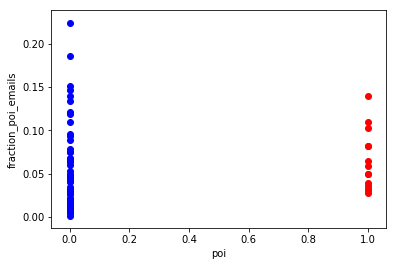

In [27]:
# let's test if this feature has any correlation with POIs
new_features_list = ['poi', 'fraction_poi_emails']
data = featureFormat(data_dict, new_features_list)

### plot
for point in data:
    poi = point[0]
    fraction_poi_emails = point[1]
    #matplotlib.pyplot.boxplot( data )
    if point[0] == 1:
        matplotlib.pyplot.scatter(poi, fraction_poi_emails, color = 'r')
    else:
        matplotlib.pyplot.scatter(poi, fraction_poi_emails, color = 'b')
    #matplotlib.pyplot.boxplot(data)
matplotlib.pyplot.xlabel("poi")
matplotlib.pyplot.ylabel("fraction_poi_emails")
matplotlib.pyplot.show()

I can see the different of fraction of poi and non-poi emails. Let's use this new feature to see if it improves the classifier.

#### Original features

In [28]:
# features_list_original
features_list = ['poi',
                 'salary',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)

# choose decision tree
t0 = time()
clf = DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

#accuracy parameters
acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'Decision Tree algorithm run time: ', round(time()-t0, 3), 's'


Accuracy: 0.793103448276
Precision:  0.142857142857
Recall:  0.142857142857
Decision Tree algorithm run time:  0.014 s


#### Add new features

In [29]:
# features_list with new feature created (fraction_poi_emails)
features_list = ['poi',
                 'salary',
                 'from_poi_to_this_person',
                 'fraction_poi_emails',
                 'from_this_person_to_poi',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

# choose decision tree
t0 = time()
clf = DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'Decision Tree algorithm run time: ', round(time()-t0, 3), 's'



Accuracy: 0.758620689655
Precision:  0.181818181818
Recall:  0.285714285714
Decision Tree algorithm run time:  0.016 s


The new feature improved recall and precision. So, I decided to use the new feature henceforth.

#### Intelligently Select Features

The next step is selecting the features that convey the most information to our model. Leaving some features out has some advantages, like reducing the noise in the classification, and saving processing time, since there are less features to compute. 

Now, we use RFE to select the best features and use them further in our analysis.

Optimal number of features : 3


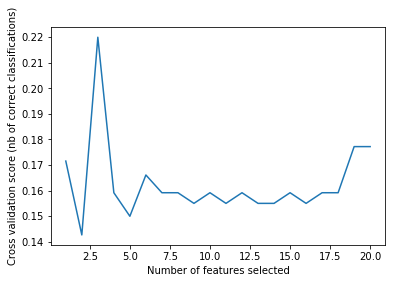

In [39]:
features_list = ['poi',
                 'salary',
                 'from_poi_to_this_person',
                 'fraction_poi_emails',
                 'from_this_person_to_poi',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

X, y = (features_train, labels_train)

# Create the RFE object and compute a cross-validated score.
DTC = DecisionTreeClassifier()

rfecv = RFECV(estimator=DTC, step=1, cv=StratifiedKFold(2),
              scoring = 'average_precision')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [40]:
# Using RFE to identify best 3 features as it is the optimal feature mix

features_list = ['poi',
                 'salary',
                 'from_poi_to_this_person',
                 'fraction_poi_emails',
                 'from_this_person_to_poi',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

# feature extraction
model =  DecisionTreeClassifier()
rfe = RFE(model, 3)
fit = rfe.fit(features_train, labels_train)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: 3
Selected Features: [False False  True False False False  True  True False False False False
 False False False False False False False False]
Feature Ranking: [18 17  1 14 13 12  1  1  8 11 16 15 10  3  9  7  5  6  4  2]


In [42]:
# Updated_features_list_as_per_RFE

features_list = ['poi',
                 'fraction_poi_emails',
                 'total_payments',
                 'exercised_stock_options']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

# choose decision tree
t0 = time()
clf = DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'Decision Tree algorithm run time: ', round(time()-t0, 3), 's'

Accuracy: 0.696428571429
Precision:  0.0769230769231
Recall:  0.166666666667
Decision Tree algorithm run time:  0.015 s



Since Decision Tree algorithm was used which does not need scaling, feature scaling was not used.


### Algorithm Selection and Tuning
I have tried Decision tree. With the small samples like that Naive Bayes may not work very well. So, let's try Random Forest, Adaboost and NearestK.

#### Random Forest

In [43]:
features_list = ['poi',
                 'fraction_poi_emails',
                 'total_payments',
                 'exercised_stock_options']


data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

t0 = time()
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'F1 score:', f1_score(labels_test, pred)
print 'Random algorithm run time: ', round(time()-t0, 3), 's'

Accuracy: 0.892857142857
Precision:  0.0
Recall:  0.0
F1 score: 0.0
Random algorithm run time:  0.128 s


C:\Users\Homagni Bhattacharje\Miniconda3\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Homagni Bhattacharje\Miniconda3\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Adaboost

In [44]:
features_list = ['poi',
                 'fraction_poi_emails',
                 'total_payments',
                 'exercised_stock_options']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

t0 = time()
clf = AdaBoostClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'F1 score:', f1_score(labels_test, pred)
print 'Adaboost algorithm run time: ', round(time()-t0, 3), 's'

Accuracy: 0.714285714286
Precision:  0.0
Recall:  0.0
F1 score: 0.0
Adaboost algorithm run time:  0.51 s


#### Logistic Regression

In [45]:
features_list = ['poi',
                 'fraction_poi_emails',
                 'total_payments',
                 'exercised_stock_options']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

t0 = time()
clf = LogisticRegression()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'F1 score:', f1_score(labels_test, pred)
print 'Logistic regression algorithm run time: ', round(time()-t0, 3), 's'

Accuracy: 0.571428571429
Precision:  0.153846153846
Recall:  0.666666666667
F1 score: 0.25
Logistic regression algorithm run time:  0.021 s


#### SVC

In [46]:
ffeatures_list = ['poi',
                 'fraction_poi_emails',
                 'total_payments',
                 'exercised_stock_options']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# split data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size = 0.4, random_state = 42)

t0 = time()
clf = svm.LinearSVC()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

acc = accuracy_score(labels_test, pred)
print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'F1 score:', f1_score(labels_test, pred)
print 'SVC algorithm run time: ', round(time()-t0, 3), 's'

Accuracy: 0.392857142857
Precision:  0.111111111111
Recall:  0.666666666667
F1 score: 0.190476190476
SVC algorithm run time:  0.025 s


After trying other algorithms, I decided to go with Decision Tree as it has the highest performance regarding overall accuracy, precision, recall and F1 score.

### Tuning by GridSearchCV

The ultimate goal of machine learning is to make a machine system that can automatically build models from data without requiring tedious and time consuming human involvement. 

One of the difficulties is that learning algorithms (eg. decision trees, random forests, clustering techniques, etc.) require you to set parameters before you use the models (or at least to set constraints on those parameters).

How we set those parameters can depend on a whole host of factors. That said, the goal, is usually to set those parameters to optimal values that enable us to complete a learning task in the best way possible. 

Thus, tuning an algorithm or machine learning technique, can be simply thought of as process which one goes through in which they optimize the parameters that impact the model in order to enable the algorithm to perform the best (once, of course you have defined what "best" actual is).

#### Decision Tree

In [47]:
# Using pipeline
pipe = Pipeline(steps=[('classifDT', DecisionTreeClassifier())])

#param grid
params = [{
    'classifDT__max_features':["sqrt","log2"],
    'classifDT__max_depth':np.arange(0,10)
}]
#Stratified_Shuffle_Split for validation

sss = StratifiedShuffleSplit(n_splits=50, test_size=0.1, train_size= None, random_state= 42, )

# run grid search
clf = GridSearchCV(estimator=pipe, 
                     param_grid=params, 
                     scoring='f1',
                     n_jobs = -1, 
                     cv= 50,
                     verbose = 1,
                     error_score = 0)

clf.fit(features_train, labels_train)

# examine the best model
print '*******Final results*********'
print clf.best_score_
print clf.best_params_
print clf.best_estimator_

#Predicted values of new best fit classifier
pred = clf.predict(features_test)


print 'Accuracy: ' + str(acc)
print 'Precision: ', precision_score(labels_test, pred)
print 'Recall: ', recall_score(labels_test, pred)
print 'Decision Tree algorithm run time: ', round(time()-t0, 3), 's'

C:\Users\Homagni Bhattacharje\Miniconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 12 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=50.
  % (min_labels, self.n_folds)), Warning)


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   31.7s


*******Final results*********
0.190476190476
{'classifDT__max_features': 'sqrt', 'classifDT__max_depth': 9}
Pipeline(memory=None,
     steps=[('classifDT', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
Accuracy: 0.392857142857
Precision:  0.333333333333
Recall:  0.166666666667
Decision Tree algorithm run time:  50.73 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   39.4s finished


The parameters ,'max_depth' and 'max_features' of DecisionTreeClassifier were tuned using GridsearchCV.
max_depth refers to the maximum depth of the tree. 
max_features refers to the number of features to consider when looking for the best split.

The parameters were tuned by running a grid with the best possible combinations for the parameters chosen and allowing the classifier to find the best fit and thus the best combination of the parametrs.

In [48]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

dump_classifier_and_data(clf.best_estimator_, my_dataset, features_list)

### Analysis Validation and Performance

The Classifier performance, here Decision Tree classifier waqs validated by fitting the best estimator parameter set with test data which is really a subset of the training data held back from the machine learning algorithms until the very end. After we have selected and tuned the machine learning algorithms on your training dataset we can evaluate the learned models on the validation dataset to get a final objective idea of how the models might perform on unseen data, which makes validation extremely important.

This validation was proceeded with the following steps uing the cross validation vodule of sklearn.
First I used accuracy to evaluate my algorithm. It was a mistake because in this case we have a class imbalance problem - the number of POIs is small compared to the total number of examples in the dataset. 
So I had to use precision and recall for these activities instead. I was able to reach value of precision and recall greater than 0.3.

Now, precision is the fraction of relevant instances among the retrieved instances, while recall is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. 

In simple terms, high precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

Wrt to this project, 0.3 cutoff for precision and recall represents 30% correct POI identified and 30% of relevant POI among the returned POI respectively.

#### Resources

1. [Sklearn documentation](http://scikit-learn.org/stable/documentation.html)
2. [StackOverflow](https://stackoverflow.com/)
3. [Github](https://github.com/)
